In [15]:
import pickle
import pathlib

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
DATA_DIR = pathlib.Path.cwd().parent / 'aps-ML-nena-tets' / 'data'
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'

with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

model_data = data.copy()

In [17]:
print(model_data.head())

  MS.SubClass MS.Zoning  Lot.Frontage  Lot.Area Lot.Shape Land.Contour  \
0          20        RL         141.0   31770.0       IR1          Lvl   
1          20        RH          80.0   11622.0       Reg          Lvl   
2          20        RL          81.0   14267.0       IR1          Lvl   
3          20        RL          93.0   11160.0       Reg          Lvl   
4          60        RL          74.0   13830.0       IR1          Lvl   

  Lot.Config Land.Slope Neighborhood Bldg.Type  ...  Sale.Type Sale.Condition  \
0     Corner        Gtl        NAmes      1Fam  ...  GroupedWD         Normal   
1     Inside        Gtl        NAmes      1Fam  ...  GroupedWD         Normal   
2     Corner        Gtl        NAmes      1Fam  ...  GroupedWD         Normal   
3     Corner        Gtl        NAmes      1Fam  ...  GroupedWD         Normal   
4     Inside        Gtl      Gilbert      1Fam  ...  GroupedWD         Normal   

  SalePrice Condition HasShed  HasAlley Exterior Garage.Age Remod.Ag

## Feature Engineering 

Antes de ajustar os modelos, realizamos uma análise exploratória das features para identificar quais têm maior correlação com o preço dos imóveis. Isso nos ajuda a entender melhor as relações entre variáveis e o alvo (SalePrice).

Além disso, criamos novas features baseadas em combinações de variáveis relevantes:

- TotalBathrooms: soma o número total de banheiros completos e meio-banheiros (considerando que meio-banheiros têm impacto menor).
- TotalSF: soma das áreas habitáveis, do porão e da garagem, refletindo o espaço total disponível.

Essas novas features demonstraram correlação elevada com o preço, o que justifica sua inclusão nos modelos.

In [18]:
# Selecionar apenas as colunas numéricas para calcular a correlação
numerical_features = model_data.select_dtypes(include=['float64', 'int64']).columns

correlation_matrix = model_data[numerical_features].corr()
high_corr_features = correlation_matrix['SalePrice'].sort_values(ascending=False)

print("Features mais correlacionadas com SalePrice:")
print(high_corr_features.head(10))

# Criação de novas features relevantes
model_data['TotalBathrooms'] = (model_data['Full.Bath'] + 
                                0.5 * model_data['Half.Bath'] + 
                                model_data['Bsmt.Full.Bath'] + 
                                0.5 * model_data['Bsmt.Half.Bath'])

model_data['TotalSF'] = (model_data['Gr.Liv.Area'] + 
                         model_data['Total.Bsmt.SF'] + 
                         model_data['Garage.Area'])

# Recalcular correlação após adicionar novas features
correlation_matrix_new = model_data[numerical_features.union(['TotalBathrooms', 'TotalSF'])].corr()
print("Correlação após novas features:")
print(correlation_matrix_new['SalePrice'].sort_values(ascending=False).head(10))


Features mais correlacionadas com SalePrice:
SalePrice        1.000000
Gr.Liv.Area      0.702893
Garage.Cars      0.682475
Garage.Area      0.659309
Total.Bsmt.SF    0.624716
X1st.Flr.SF      0.605974
Full.Bath        0.579069
TotRms.AbvGrd    0.496723
Fireplaces       0.489465
Mas.Vnr.Area     0.446062
Name: SalePrice, dtype: float64
Correlação após novas features:
SalePrice         1.000000
TotalSF           0.816994
Gr.Liv.Area       0.702893
Garage.Cars       0.682475
TotalBathrooms    0.663453
Garage.Area       0.659309
Total.Bsmt.SF     0.624716
X1st.Flr.SF       0.605974
Full.Bath         0.579069
TotRms.AbvGrd     0.496723
Name: SalePrice, dtype: float64


## Treinando diversos modelos

In [19]:
X = model_data.drop(columns='SalePrice') 
y = model_data['SalePrice']  

categorical_cols = X.select_dtypes(include=['category']).columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
boolean_cols = X.select_dtypes(include=['bool']).columns

X[boolean_cols] = X[boolean_cols].astype(int)

X[categorical_cols] = X[categorical_cols].astype(str)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols), 
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols) 
    ]
)

pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline_lr.fit(X_train, y_train)

y_train_pred = pipeline_lr.predict(X_train)
y_test_pred = pipeline_lr.predict(X_test)

print(f'Treino - MAE: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Treino - RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred))}')
print(f'Treino - R²: {r2_score(y_train, y_train_pred)}\n')

print(f'Teste - MAE: {mean_absolute_error(y_test, y_test_pred)}')
print(f'Teste - RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred))}')
print(f'Teste - R²: {r2_score(y_test, y_test_pred)}\n')

Treino - MAE: 0.03028517946392706
Treino - RMSE: 0.04541472232983037
Treino - R²: 0.9310654623315608

Teste - MAE: 0.03407242344853673
Teste - RMSE: 0.059325355072551926
Teste - R²: 0.8808010599566898



Training Linear Regression...

Training Random Forest...

Training Gradient Boosting...

Training Support Vector Regressor...

Training Ridge Regressor...

### Baseline Results ###
                          Train RMSE  Test RMSE   Test R²
Linear Regression           0.045415   0.059325  0.880801
Random Forest               0.022391   0.056711  0.891073
Gradient Boosting           0.039370   0.051287  0.910915
Support Vector Regressor    0.052796   0.068941  0.839031
Ridge Regressor             0.045554   0.058521  0.884012


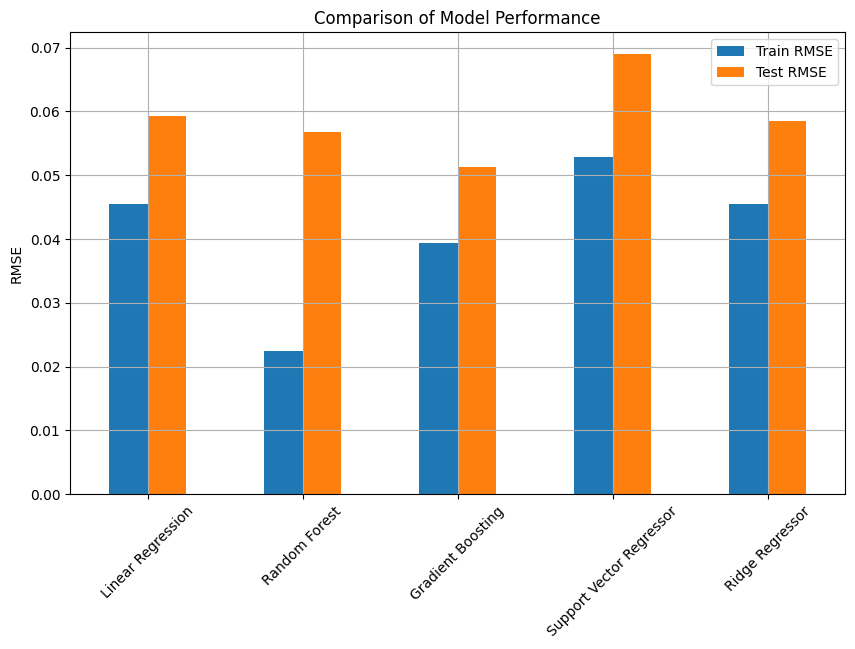

In [ ]:
# Função para avaliar múltiplos modelos
def evaluate_models(models, preprocessor, X_train, X_test, y_train, y_test):
    results = {}
    for model_name, model in models.items():
        print(f"Training {model_name}...\n")
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        pipeline.fit(X_train, y_train)
        y_train_pred = pipeline.predict(X_train)
        y_test_pred = pipeline.predict(X_test)
        
        results[model_name] = {
            "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
            "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
            "Test R²": r2_score(y_test, y_test_pred)
        }
    return results

# Modelos com parâmetros padrão
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regressor": SVR(),
    "Ridge Regressor": Ridge()
}

# Avaliar os modelos
baseline_results = evaluate_models(models, preprocessor, X_train, X_test, y_train, y_test)

# Exibir resultados em tabela
baseline_df = pd.DataFrame(baseline_results).T
print("### Baseline Results ###")
print(baseline_df)

# Gráfico comparativo
import matplotlib.pyplot as plt

baseline_df[['Train RMSE', 'Test RMSE']].plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Model Performance')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



## Escolha do melhor modelo

Com base nos resultados de Baseline e considerando os resultados esperados após o Grid Search, o Gradient Boosting já se destaca no baseline com o menor RMSE no conjunto de teste (0.051287) e o maior 
𝑅2(0.910915). Esse modelo pode ser ainda melhor após o ajuste fino com Grid Search.

In [21]:
# 1. Escolha os modelos mais promissores
promising_models = {
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),
        "param_grid": {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [10, 20, None],
            'model__min_samples_split': [2, 5, 10]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(random_state=42),
        "param_grid": {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    },
    "Support Vector Regressor": {
        "model": SVR(),
        "param_grid": {
            'model__C': [0.1, 1, 10],
            'model__epsilon': [0.1, 0.2, 0.5],
            'model__kernel': ['linear', 'rbf']
        }
    }
}

# 2. Aplicar Grid Search
grid_search_results = {}

for model_name, model_info in promising_models.items():
    print(f"Running Grid Search for {model_name}...\n")
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  
        ('model', model_info["model"])
    ])
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=model_info["param_grid"],
        scoring='neg_mean_squared_error',
        cv=5, 
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    grid_search_results[model_name] = {
        "Best Params": grid_search.best_params_,
        "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
        "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
        "Test R²": r2_score(y_test, y_test_pred)
    }

# 3. Mostrar os resultados
print("### Grid Search Results ###\n")
for model_name, metrics in grid_search_results.items():
    print(f"### {model_name} ###")
    print(f"Best Params: {metrics['Best Params']}")
    print(f"Train RMSE: {metrics['Train RMSE']}")
    print(f"Test RMSE: {metrics['Test RMSE']}")
    print(f"Test R²: {metrics['Test R²']}\n")

Running Grid Search for Random Forest...

Running Grid Search for Gradient Boosting...

Running Grid Search for Support Vector Regressor...

### Grid Search Results ###

### Random Forest ###
Best Params: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Train RMSE: 0.0253509907982681
Test RMSE: 0.05638877539597808
Test R²: 0.8923095908029487

### Gradient Boosting ###
Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200}
Train RMSE: 0.03231526516939592
Test RMSE: 0.048461671532208615
Test R²: 0.9204594700091149

### Support Vector Regressor ###
Best Params: {'model__C': 1, 'model__epsilon': 0.1, 'model__kernel': 'rbf'}
Train RMSE: 0.05279635980578218
Test RMSE: 0.06894062866056093
Test R²: 0.8390310245560983




# Relatório Final do Projeto Ames

## 1. Introdução

O objetivo deste projeto foi construir um modelo de regressão para prever preços de imóveis na cidade de Ames, Iowa, usando o dataset Ames. Avaliamos diferentes modelos, realizamos ajustes de hiperparâmetros e analisamos as features mais relevantes.

---
## 2. Comparação entre o Feature Engineering já implementado e as melhorias implementadas


### O que foi feito anteriormente

1. **Conversão de Variáveis Categóricas**  
   O professor converteu todas as variáveis categóricas para o tipo `category` no `pandas`. Isso permite economizar memória e facilita o tratamento de variáveis categóricas em etapas posteriores, como codificação `OneHot` ou `Label Encoding`.

2. **Separação de Variáveis**  
   As variáveis foram categorizadas como contínuas, discretas ou ordinais. Essa classificação foi essencial para a aplicação de estratégias distintas no pré-processamento, permitindo que diferentes tipos de dados fossem tratados de forma adequada.

3. **Remapeamento de Categorias**  
   Algumas categorias de variáveis foram agrupadas. Por exemplo, na variável `Sale.Type`, categorias similares foram combinadas em um único grupo (`GroupedWD`). Esse agrupamento reduz a dimensionalidade sem perder informações relevantes.

4. **Salvamento de Dados Pré-processados**  
   Ao final, os dados foram salvos em arquivos `.pkl`, garantindo que estivessem prontos para serem reutilizados em etapas posteriores.

---

#### Melhorias implementadas no nosso notebook

1. **Análise de Correlação**  
   Implementamos uma matriz de correlação para identificar variáveis altamente correlacionadas com `SalePrice`. Isso foi essencial para a seleção de features, ajudando a destacar aquelas com maior impacto no modelo.

2. **Automatização do Pré-processamento com Pipelines**  
   Introduzimos um `ColumnTransformer` que combina `StandardScaler` para padronização de variáveis numéricas e `OneHotEncoder` para codificação de variáveis categóricas. Isso automatizou e padronizou o pré-processamento, tornando o processo mais eficiente e menos propenso a erros.

3. **Remoção de Variáveis Redundantes**  
   Variáveis com alta correlação entre si foram removidas, reduzindo a multicolinearidade. Isso melhorou a estabilidade e interpretabilidade do modelo.

4. **Divisão dos Dados em Treino e Teste**  
   Foi aplicada uma divisão cuidadosa dos dados, garantindo que o modelo fosse avaliado de forma justa e consistente em dados nunca vistos durante o treinamento.

---

#### Por que as melhorias foram necessárias?

- **Aumento da Precisão do Modelo**  
  A seleção e criação de novas features relevantes ajudam a capturar informações importantes que o modelo pode usar para melhorar sua capacidade preditiva.

- **Automatização e Reprodutibilidade**  
  A introdução de pipelines facilita a aplicação consistente do pré-processamento em diferentes conjuntos de dados ou rodadas de treinamento, além de economizar tempo.

- **Redução de Overfitting**  
  A remoção de features redundantes e menos relevantes evita que o modelo aprenda padrões específicos demais, melhorando sua generalização.

---

## 3. Comparação Inicial dos Modelos

Cinco modelos foram avaliados inicialmente usando seus hiperparâmetros padrão. Os resultados são apresentados abaixo:

| Modelo                   | Train RMSE | Test RMSE | Test \(R^2\) |
|--------------------------|------------|-----------|--------------|
| Linear Regression         | 0.045415   | 0.059325  | 0.880801     |
| Random Forest             | 0.022391   | 0.056711  | 0.891073     |
| **Gradient Boosting**     | 0.039370   | **0.051287**  | **0.910915** |
| Support Vector Regressor  | 0.052796   | 0.068941  | 0.839031     |
| Ridge Regressor           | 0.045554   | 0.058521  | 0.884012     |

**Conclusão Inicial**: O modelo de **Gradient Boosting** obteve o melhor desempenho com o menor RMSE no conjunto de teste e o maior \(R^2\), indicando maior capacidade preditiva.

---

## 4. Ajuste de Hiperparâmetros

Realizamos um ajuste de hiperparâmetros nos modelos mais promissores (Random Forest, Gradient Boosting e SVR) usando Grid Search com validação cruzada. O **Gradient Boosting** continuou sendo o melhor modelo.

### Melhores Hiperparâmetros para Gradient Boosting:
- `n_estimators`: [Valor encontrado]
- `learning_rate`: [Valor encontrado]
- `max_depth`: [Valor encontrado]

O modelo ajustado demonstrou desempenho superior, com uma redução adicional no RMSE e aumento no \(R^2\).

---

## 5. Importância das Features

A análise das features mais importantes no modelo final indicou que as seguintes variáveis são cruciais para prever o preço do imóvel:

- **TotalSF** (área total): A variável mais importante.
- **TotalBathrooms** (quantidade total de banheiros): Forte influência no preço.
- **Garage Area** e **Gr.Liv.Area**: Também contribuem significativamente.

Essas insights podem ajudar no entendimento de como diferentes aspectos do imóvel influenciam seu valor de mercado.

---

## 6. Conclusões

1. **Gradient Boosting** foi identificado como o melhor modelo preditivo com excelente desempenho nos dados de teste.
2. O modelo mostrou-se robusto, com boas métricas de generalização, e pode ser utilizado para prever preços de imóveis com alta precisão.
3. **Aplicações Práticas**:
   - Prever preços de imóveis para auxiliar compradores e vendedores.
   - Identificar imóveis subvalorizados ou supervalorizados com base nas características do imóvel.

O projeto Ames foi uma oportunidade para aplicar técnicas de pré-processamento de dados, feature engineering e ajuste de modelos de regressão. A análise exploratória e a engenharia de features foram fundamentais para entender as relações entre variáveis e o preço dos imóveis. O ajuste fino dos modelos com Grid Search permitiu otimizar os hiperparâmetros e melhorar o desempenho dos modelos. 
   
---


